In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pickle
import numpy as np

In [2]:
nlct_path = "/home/jturner/false_low_clouds_2023/Nighttime_Low_Cloud_Test/data/"

In [3]:
filename = 'goes_e_ntlc_2023_09_01_00H_50M'

file = open(nlct_path+filename, 'rb')
BTD = pickle.load(file)
file.close()

In [14]:
#---Northeast US
# min_lon = -83
# min_lat = 26
# max_lon = -51
# max_lat = 50

#---Chilean Coast
min_lon = -95
min_lat = -37
max_lon = -65
max_lat = -10

In [15]:
BTD_masked = BTD[0].where(BTD[0] >= 0, 0)

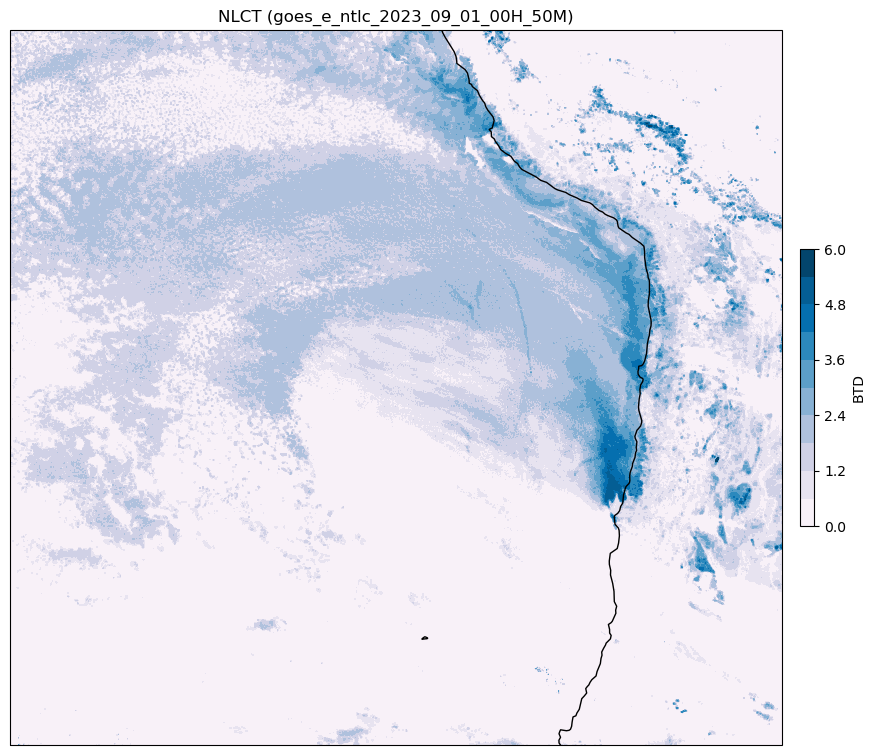

In [18]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.PuBu
levels = np.linspace(0, 6, 11)

ax.set_extent([min_lon, max_lon, min_lat, max_lat])
c=ax.contourf(BTD.lon, BTD.lat, BTD_masked, cmap=cmap, extend='neither', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('NLCT ('+filename+')')
clb.set_label('BTD')

ax.coastlines(resolution='50m', color='black', linewidth=1)